In [147]:
%pip install numpy pandas matplotlib seaborn tensorflow keras xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Auto-mpg dataset

We are predicting MPG based off of other features in the dataset:
 - displacement (countinous)
 - horsepower (countinous)
 - weight (countinous)
 - acceleration (countinous)
 - cylinders (discrete)
 - model year (discrete)
 - origin (discrete)
 - car name (unique string)

We can already see that some features are going to be more important than others, and that some features are going to be more difficult to work with than others. For example, the car name is a unique string, and therefore we can't use that as a feature without some sort of encoding, and so we will evaluate if this feature is worth keeping or not. To understand the features better we can import the dataset and have a look at it.

In [148]:
import pandas as pd
# Load dataset
# I've done some preprocessing on the dataset to convert it to a csv file, from a tsb file (and replaced missing values (?) with nothing so they are treated as NA values)
df = pd.read_csv("data/auto-mpg.csv")
print(df.head())
print(df.isna().sum())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model year  origin                   car name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino  
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


## Data preparation:

### NA Values 

We can see that there are some missing values in the horsepower column, we can either drop these rows or replace them with the mean value. For now we will remove them, but if we find that horsepower is not a very important feature we might want to reintroduce them using the mean value. However, we will remove them as they only account for ~1.5% of our dataset.

In [149]:
df.dropna(inplace=True)
print(df.isna().sum())

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


### Feature engineering

#### Correlation

We can plot the features of the dataset against the MPG to see if which features have a correlation with MPG.

We can see that displacement, horsepower, and weight all have a clear correlation with mpg. Acceleration however, is scattered and thus does not show much correlation to mpg. Looking at the discrete features we can see that the different values are grouped at different ranges of mpg, this means they are correlated with mpg in some way, however we cannot use them in their current form, so we will have to encode them.

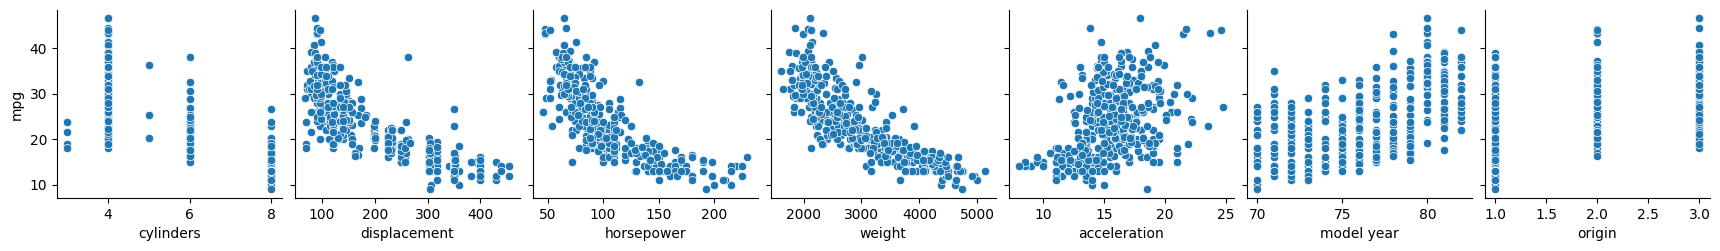

In [150]:
# Plot features against mpg in pairplot
import seaborn as sns
sns.pairplot(df, x_vars=df.drop(["mpg", "car name"], axis=1, inplace=False).columns, y_vars=["mpg"])

#### Car name feature

The carname feature is a unique string, thus we cannot use it as a feature (at least not in its current form), since the model will only be trained on a single instance of each car name (since the car name is unique), but also the model will not be able to generalize to new car names. In addition to this, encoding the car name would be very difficult because there are 301 unique car names, thus we would add 301 features to our model. This means we are likely to suffer the consequences of the curse of dimensionality.
We can however use it to create a new feature, the brand name column is the first word in the car name. This will reduce the number of unique values to 37, which is still a lot, but we could use them as features.

Unique car names: 301
Unique brand names: 37


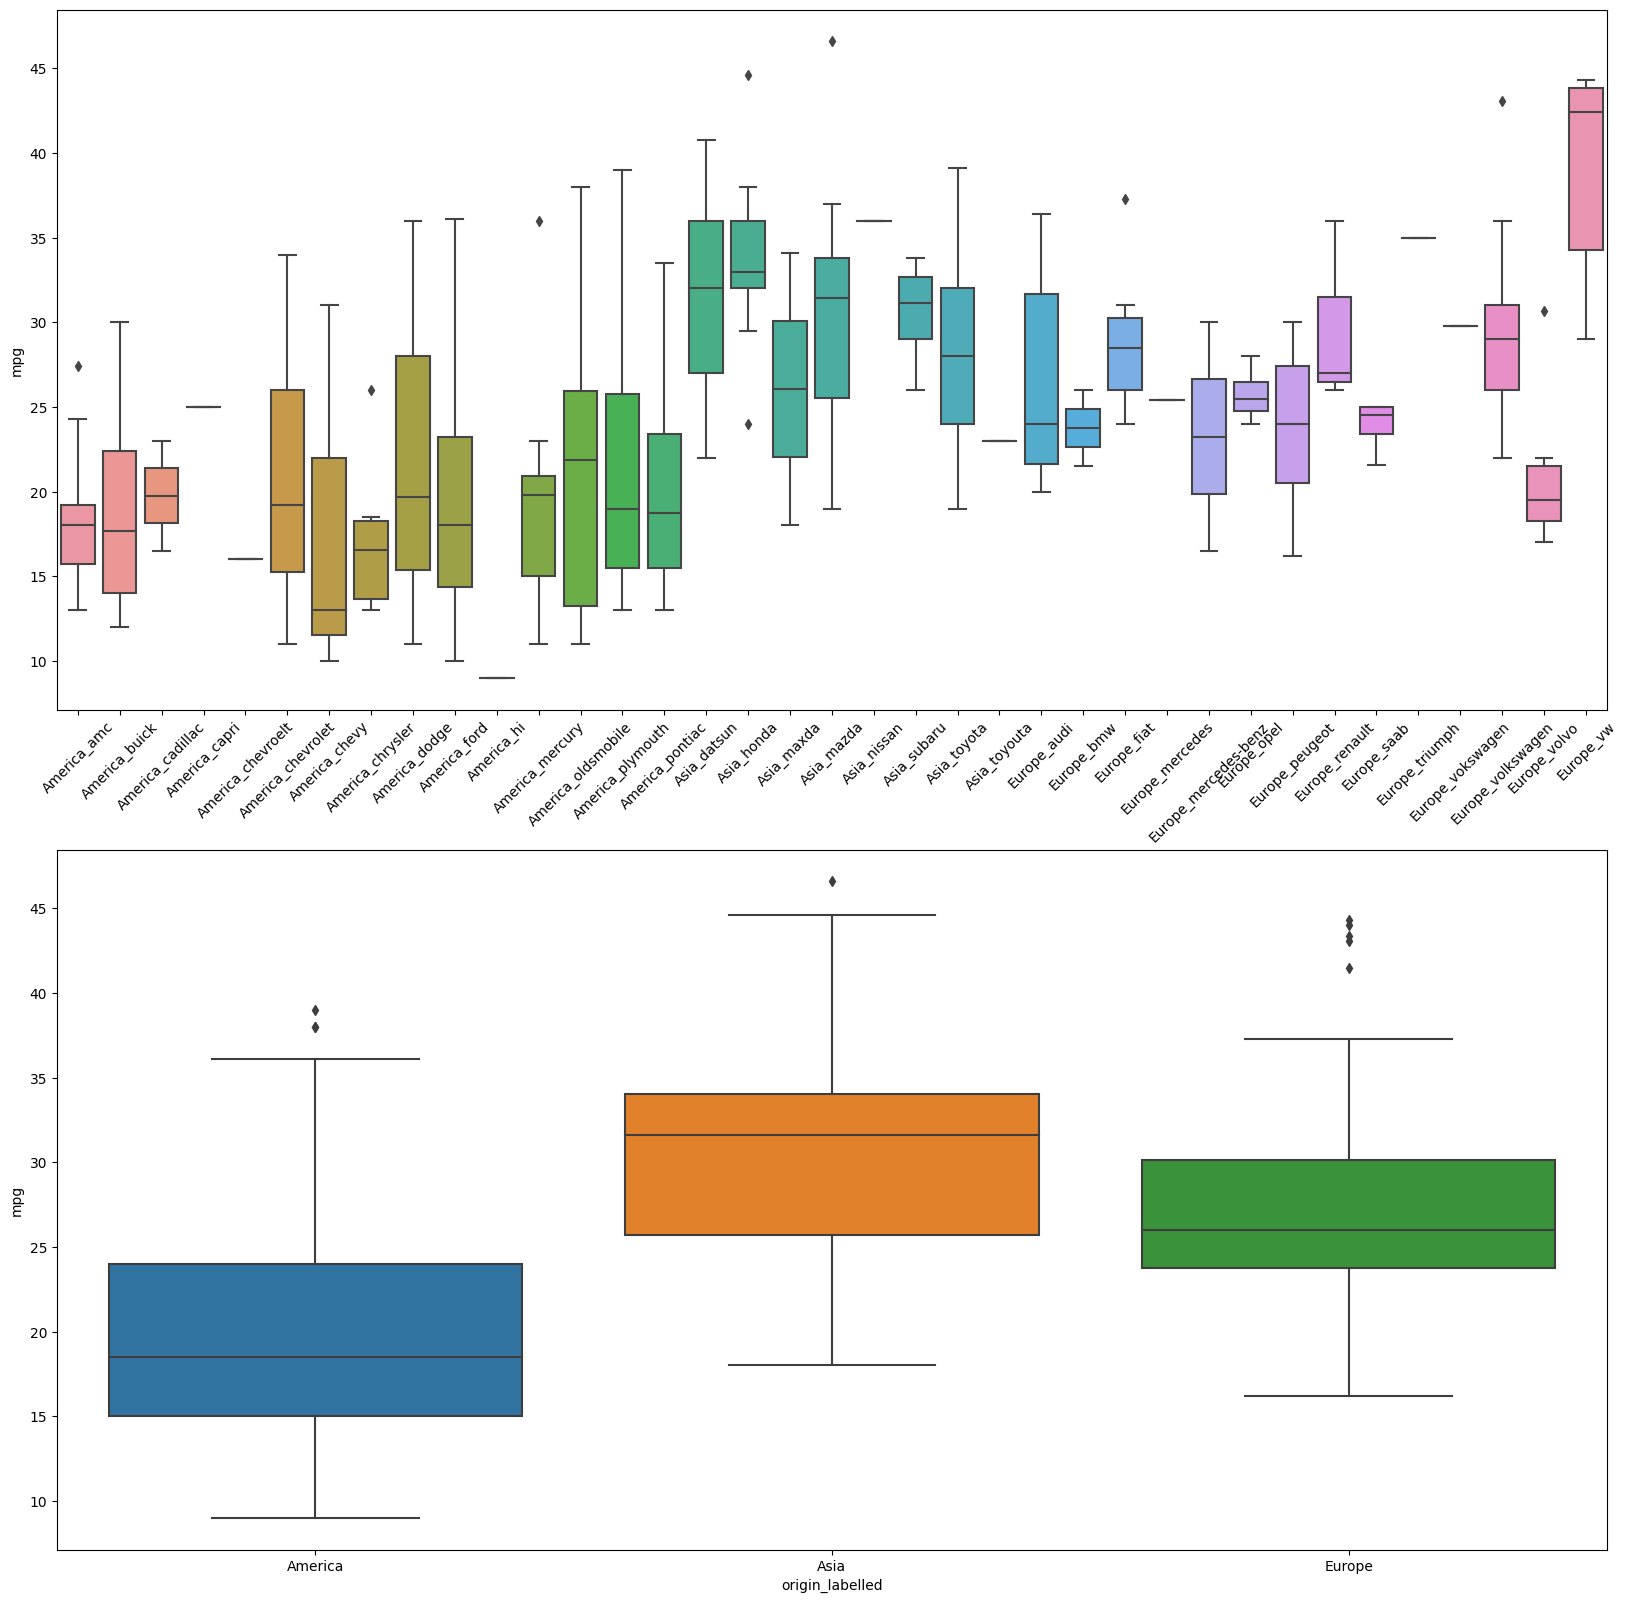

In [151]:
import matplotlib.pyplot as plt
# show count of unique car names
print(f"Unique car names: {len(df['car name'].unique())}")
# car names are in the format "brand name model name"
# Show count of unique brand names
print(f"Unique brand names: {len(df['car name'].apply(lambda x: x.split()[0]).unique())}")

# Add brands as a column prefixed with orgin_old
df["origin_labelled"] = df["origin"].map({1: "America", 2: "Europe", 3: "Asia"})
df["brand"] = df["origin_labelled"] + "_" + df["car name"].apply(lambda x: x.split()[0])
# Plot correlation of brand to MPG, sorting brands by alphabetical order, with a large figure size and the correlation of mpg to origin_labelled below
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
# Rotate x-axis labels 45 degrees
plt.setp(ax1.get_xticklabels(), rotation=45)
sns.boxplot(x="brand", y="mpg", data=df, order=sorted(df["brand"].unique()), ax=ax1)
sns.boxplot(x="origin_labelled", y="mpg", data=df, order=sorted(df["origin_labelled"].unique()), ax=ax2)
plt.show()


Plotting brand names and grouping them by origin, we can observe that there is a relationship between the brand name and MPG. However, I think that we are better off just using the origin, as brands from a similar origin are likely to have similar mpg because MPG is very commonly marketed as a feature of the car, creating competition among brands to match / beat each other. This means that the brand name is not a very good feature, and we should drop it.

Another benefit to this is that the brand data is quite dirty, there are some brands that are misspelled ('toyouta') and some that are listed twice ('volkswagen' and 'vw'). This would be quite difficult to clean up, and we would have to add a lot of features to our model, so dropping it is the best option.

This also has the added benefit that our model will perform better on brands that aren't in the dataset.

#### Categorical features

We can see that the cylinders, model year and origin features are categorical and despite the fact we would like these to be distributed evenly (uniformly), they are not.
America makes up the majority of the cars in the dataset, this could cause our model to not generalise well to other origins, but given our small dataset we will have to accept this. 

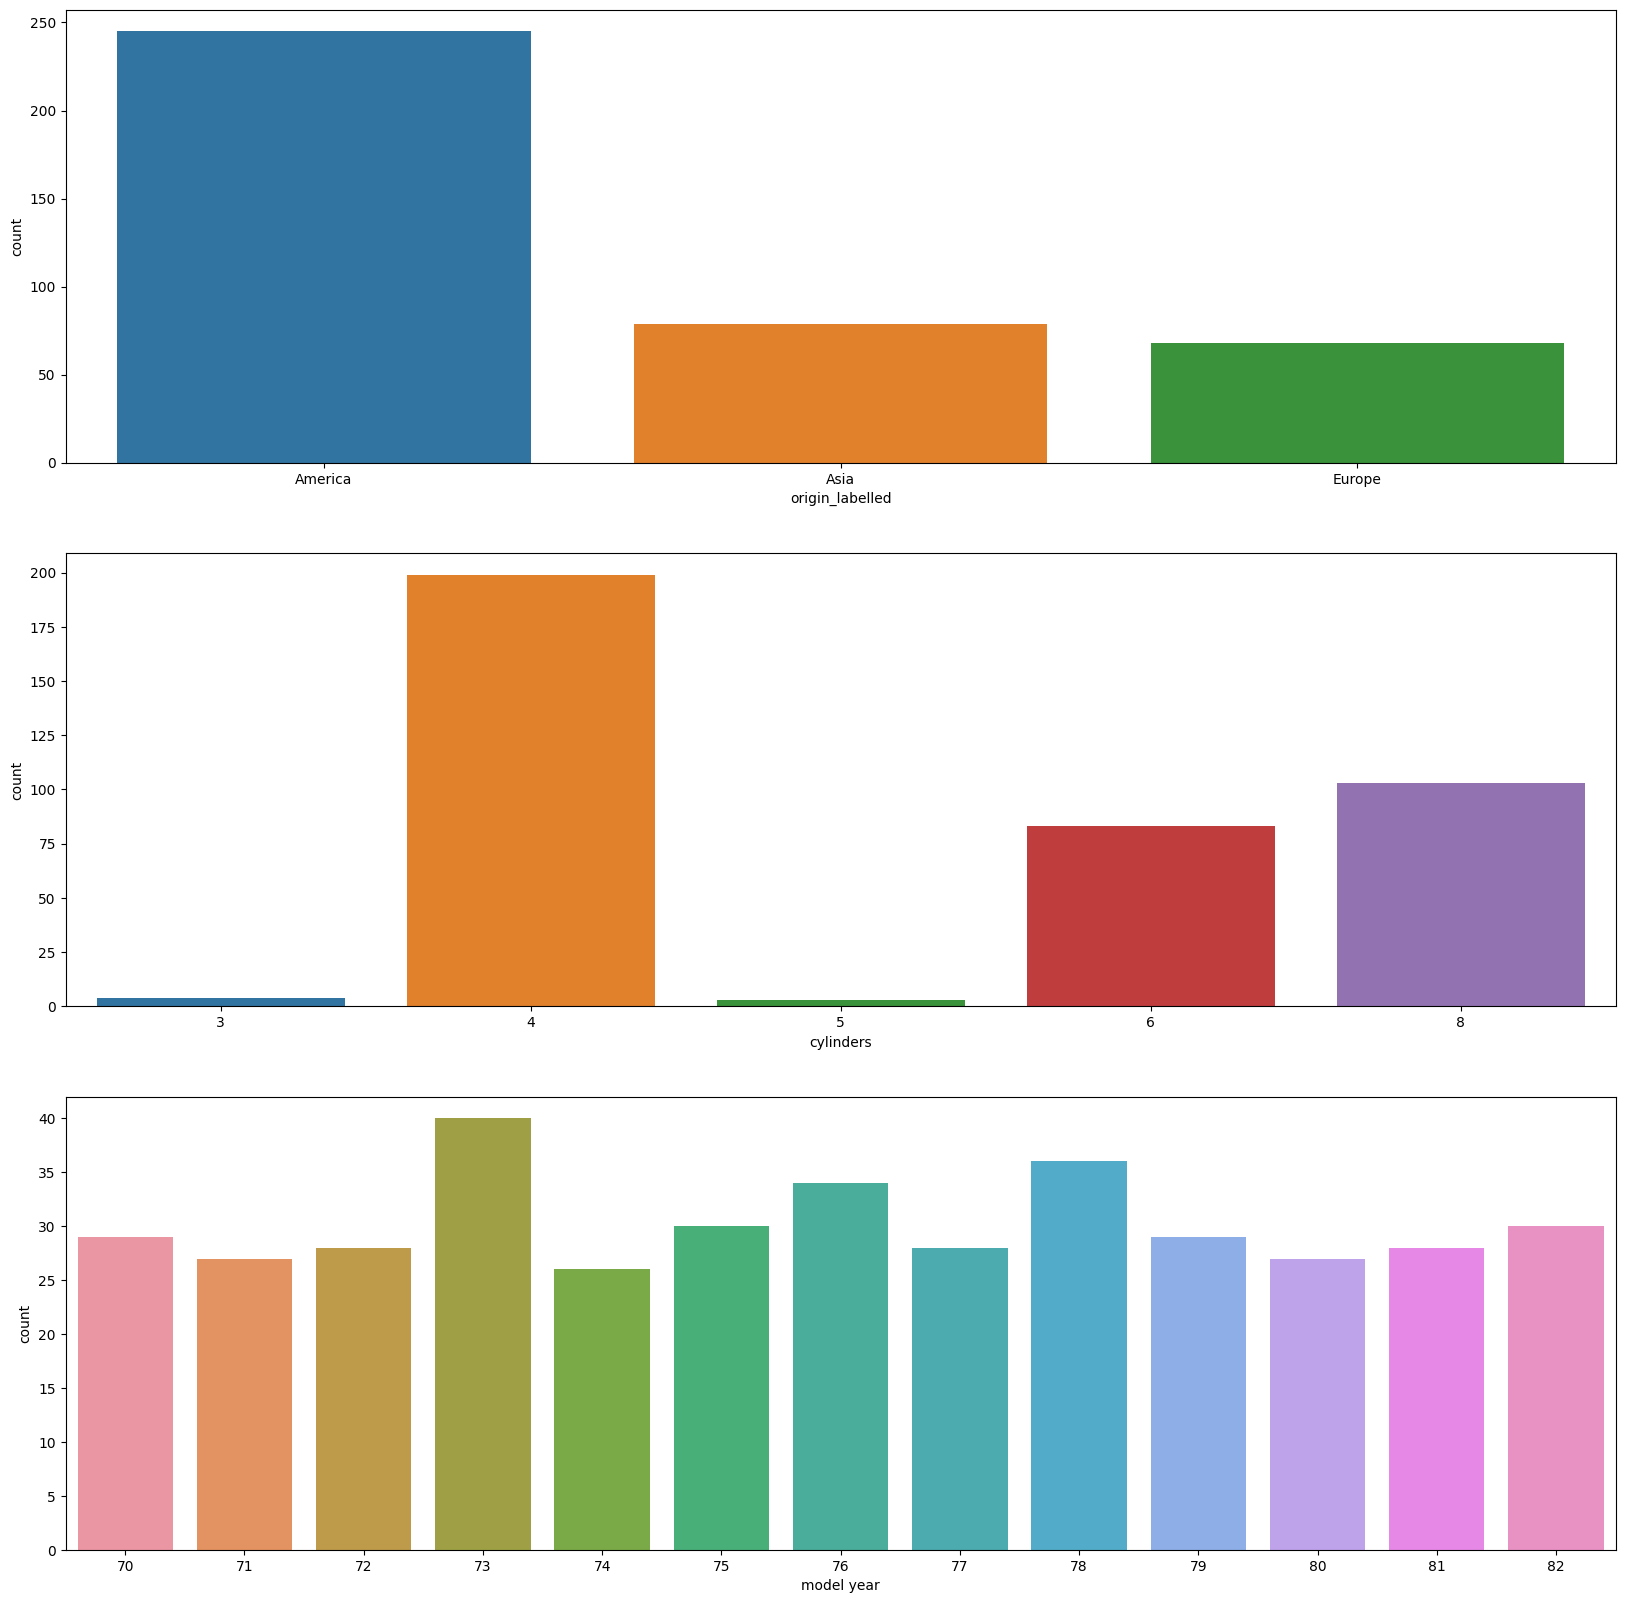

In [152]:
# Three sns.countplot, each one is plot of value counts of a column, the columns are the categorical features (origin, cylinders, model year)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
sns.countplot(x="origin_labelled", data=df, ax=ax1)
sns.countplot(x="cylinders", data=df, ax=ax2)
sns.countplot(x="model year", data=df, ax=ax3)
plt.show()


The cylinders feature is not distributed evenly, there are very few values for 3 and 5 cylinders, we should also look at how these cylinders are distributed across the different origins.

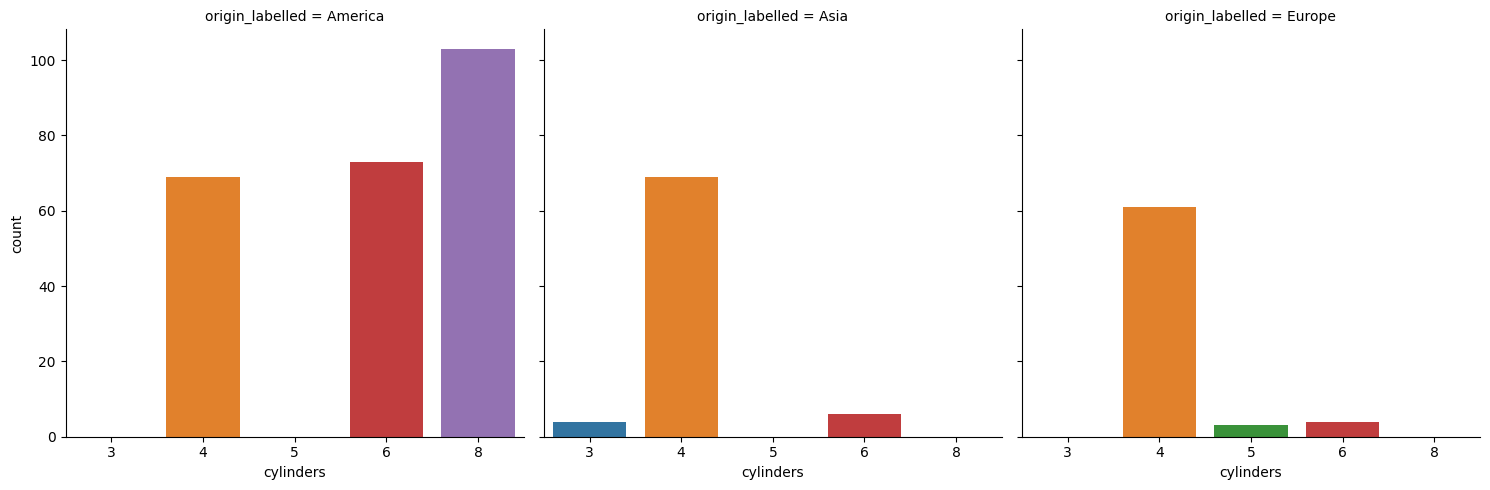

In [153]:
# Show distibution of cylinders, grouped by origin_labelled
sns.catplot(x="cylinders", col="origin_labelled", data=df, kind="count")
plt.show()

The only common factor in the feature is that all the origins have a similar number of cars with 4 cylinders, otherwise the distribution is quite different. I suspect that cylinders will have a high colinearity with displacement, because more cylinder means more air to displace, if this is true we will drop the column.

#### Feature correlation

We can plot the correlation matrix to see if there are any features that are highly correlated with each other because we are interested in features that are highly correlated to mpg specifically, however if two features are highly correlated to each other we can drop one of them (colinearity).

Feature      : correlation coefficent.
weight       : 0.83
displacement : 0.81
horsepower   : 0.78
acceleration : 0.42


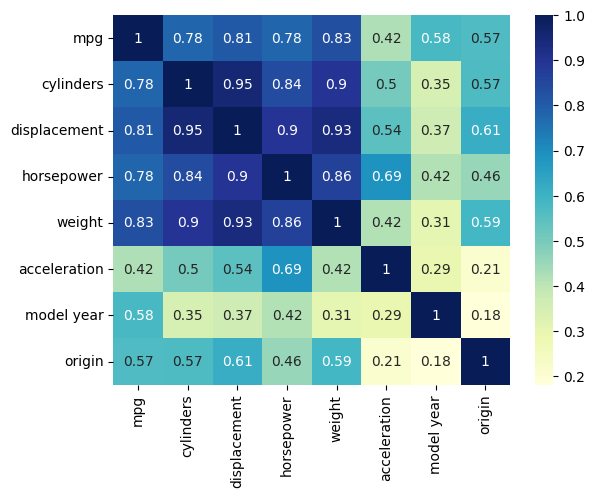

In [154]:
continuous = ["mpg", "displacement", "horsepower", "weight", "acceleration"]
categorical = ["cylinders", "origin_labelled", "model year"]

# heatmap of absolute correlation of continous features
sns.heatmap(df.corr().abs(), annot=True, cmap="YlGnBu")

# Correlation of each feature to MPG
print(f"{'Feature':12} : correlation coefficent.")
correlations = dict()
for feature in continuous:
    if not feature == "mpg":
        correlations[feature] = abs(df[feature].corr(df['mpg']))

# Sort correlations by value (highest to lowest) then print
for key, value in sorted(correlations.items(), key=lambda item: item[1], reverse=True):
    print(f"{key:12} : {value:0.2f}")

We can see that there is a weak correlation between mpg and acceleration, and a strong correlation between mpg and displacement, horsepower, cylinders (confirming my earlier hypothesis), and weight. Since the correlation between these features is so strong, so we will drop displacement and cylinders, as they provide very little additional information gain.

#### Feature pruning

Based on the above we will drop some features from the dataset:
- Car name
- Cylinders
- Displacement
  
Which means dropping the following columns:
- Car name
- Cylinders
- Displacement
- origin (replaced with origin_labelled)
- brand

In [155]:
df.drop("car name", axis=1, inplace=True)
df.drop("cylinders", axis=1, inplace=True)
df.drop("displacement", axis=1, inplace=True)
df.drop("origin", axis=1, inplace=True)
df.drop("brand", axis=1, inplace=True)

continuous = ["mpg", "horsepower", "weight", "acceleration"]
discete = ["origin_labelled", "model year"]

#### Outliers

We can look for outliers in the data using boxplots. Outliers in our training data can impact our model, so we should remove them. This is especially important if we choose a model that does not handle outliers well, such as linear regression.

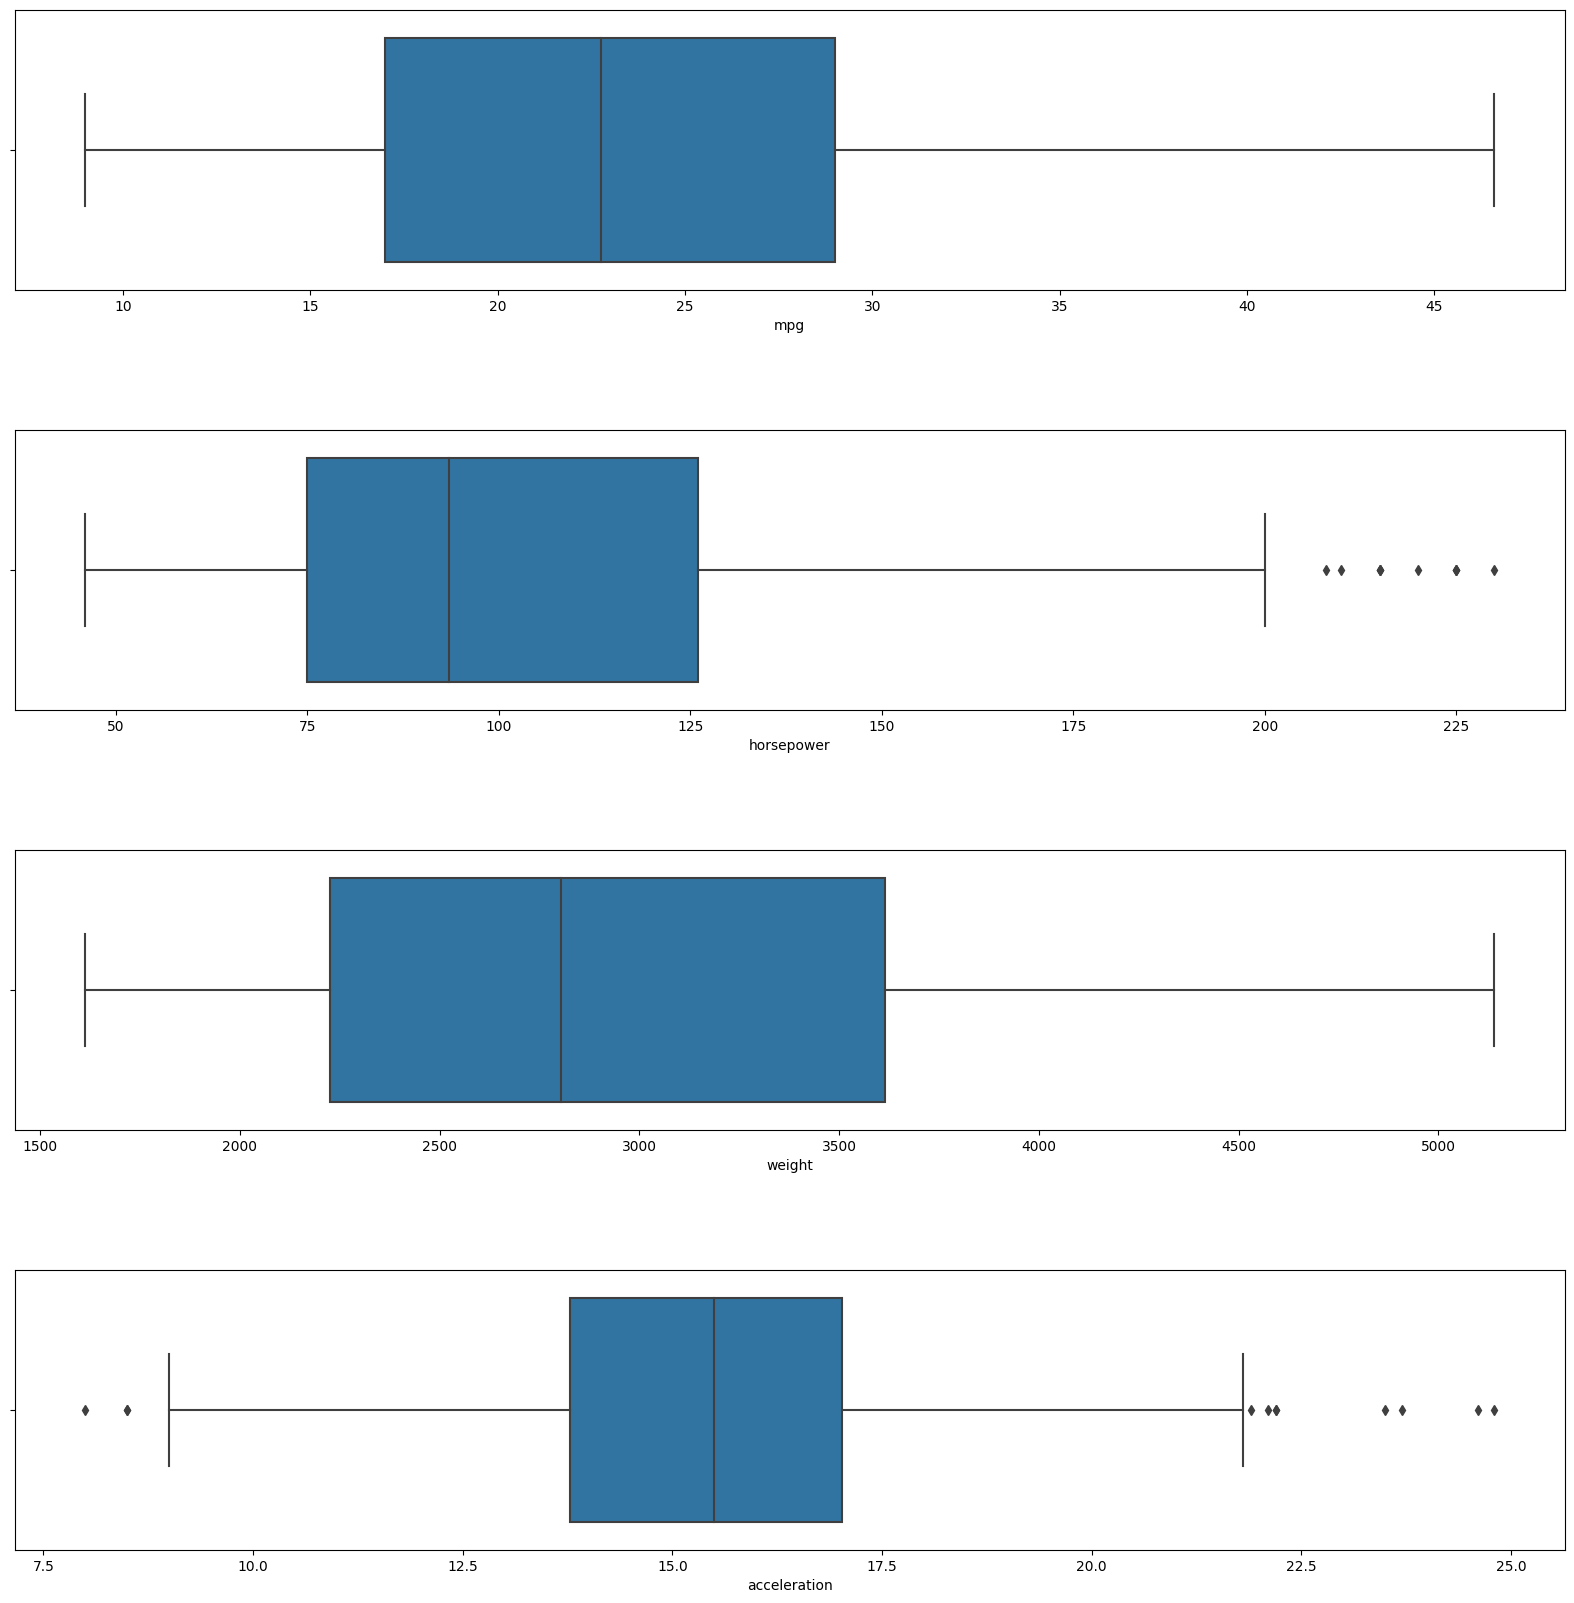

In [156]:
def plot_outliers(df, columns=continuous): # Default to all continuous features
    fig, axes = plt.subplots(len(columns), 1, figsize=(20, 20))
    for i, column in enumerate(columns):
        sns.boxplot(x=column, data=df, ax=axes[i])
    plt.subplots_adjust(hspace=0.5)
    plt.show()

plot_outliers(df)

Here we see that there are some outliers in the horsepower and acceleration features therefore we will remove the horsepower outliers; we will drop all of these rows; as they could be a result of a mistake in data collection; and we don't want to introduce bias into our model.

We will remove the outliers using tukey fences, which use the interquartile range to determine the outliers.

Removed   0 rows from mpg
Removed  10 rows from horsepower
Removed   0 rows from weight
Removed   9 rows from acceleration


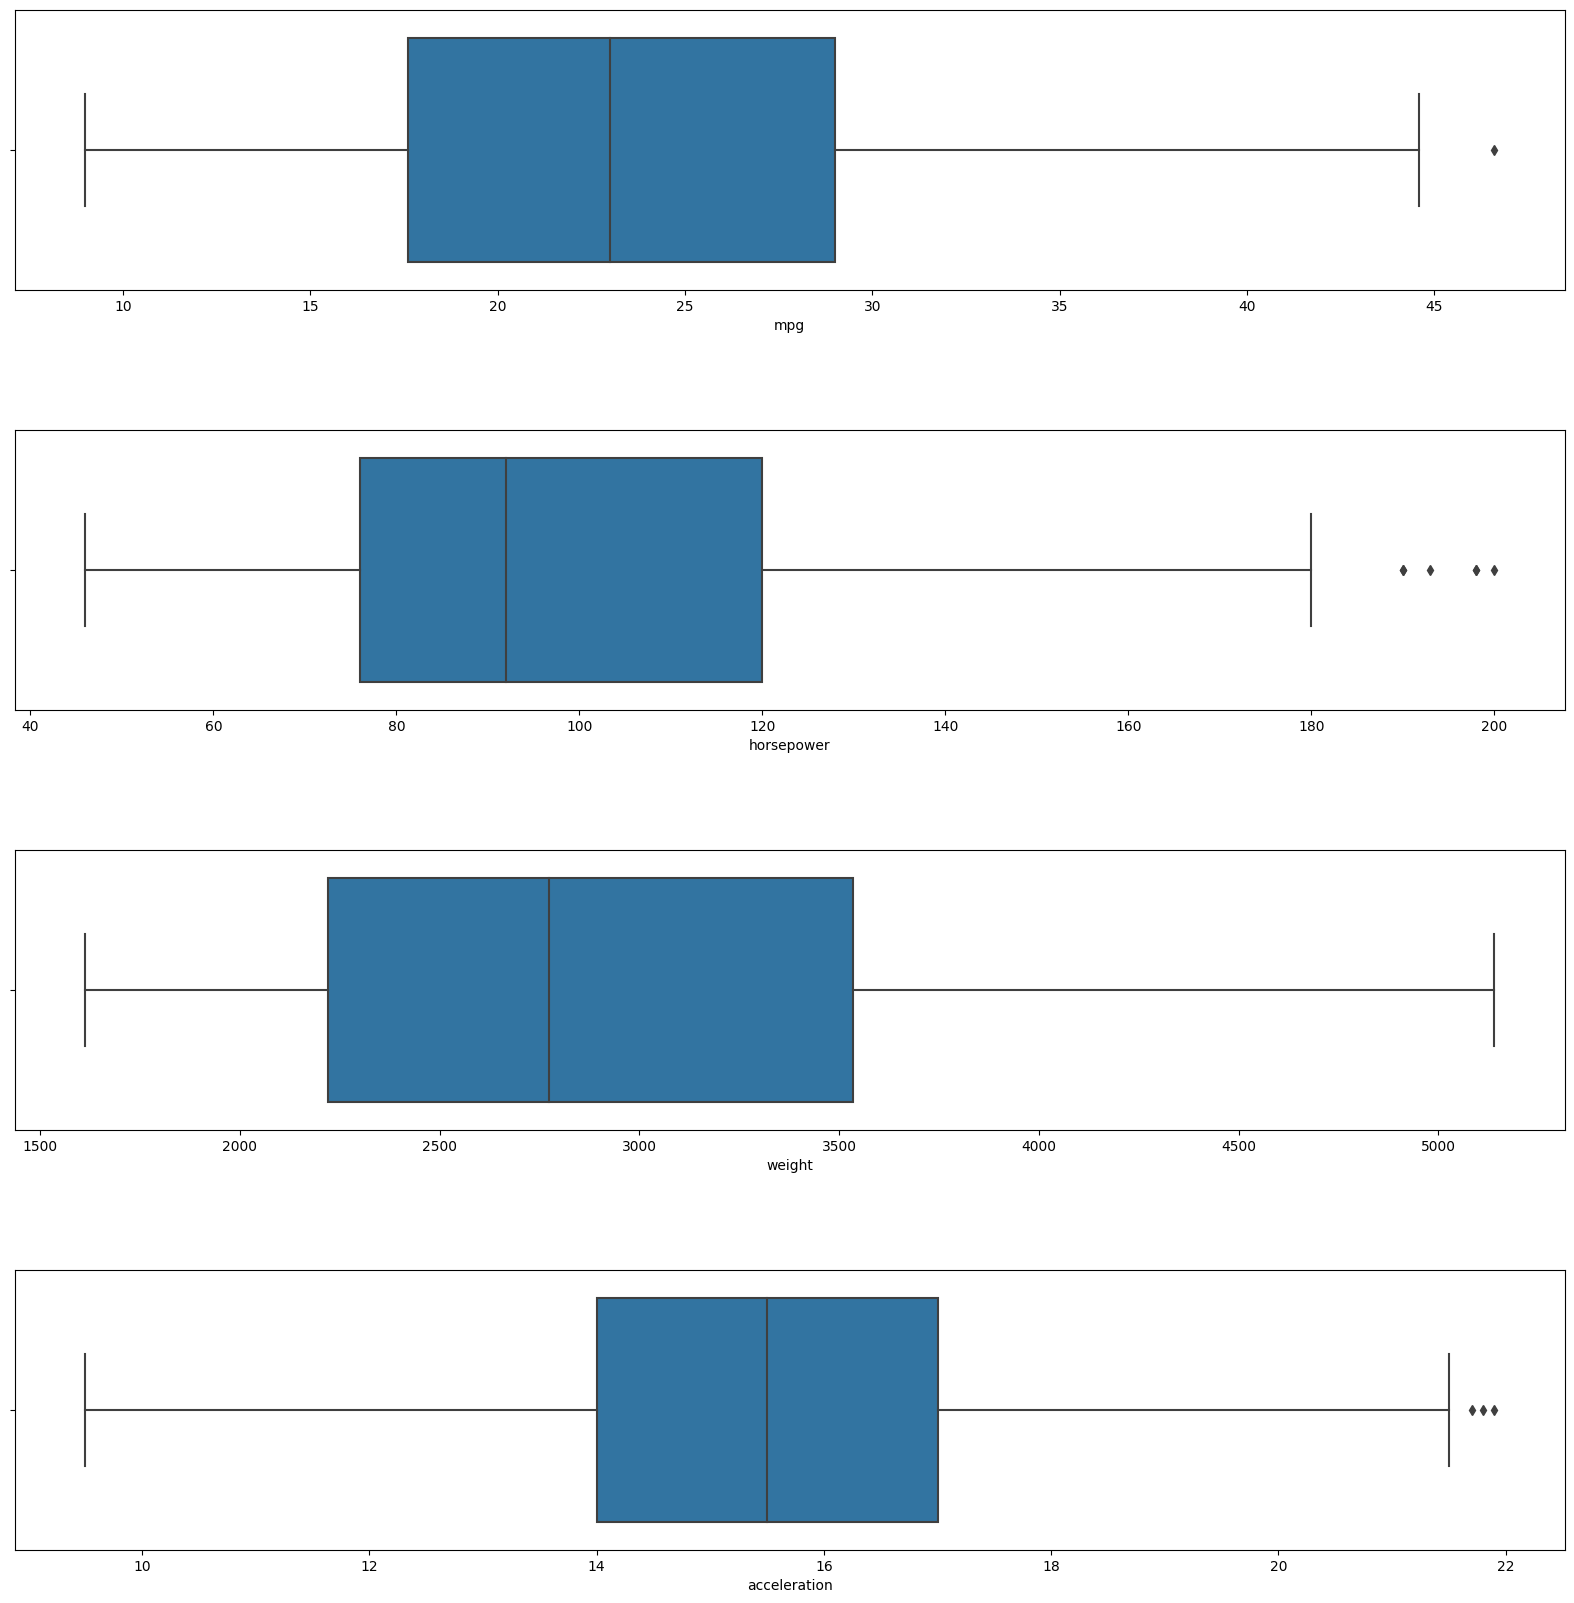

In [157]:
# Function that removes outliers based on tukey fences, and prints how many rows were removed for each column
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - 1.5*iqr
    fence_high = q3 + 1.5*iqr
    print(f"Removed {len(df.loc[(df[column] < fence_low) | (df[column] > fence_high)]):3} rows from {column}")
    return df.loc[(df[column] > fence_low) & (df[column] < fence_high)]

# Remove outliers from all columns except for Asia, Europe, America
for column in continuous:
    df = remove_outliers(df, column)

# Plot outliers again to see if they have been removed
plot_outliers(df)

#### Feature preperation

##### Categorical features

We have two options for categorical features, label encoding and one-hot encoding. Label encoding is a simple way to encode categorical features, it assigns each unique value in the feature a number, however this can cause the model to think that there is a relationship between the different values, when there is not. One-hot encoding is a more complex way to encode categorical features, it creates a new column for each unique value in the feature, and assigns a 1 or 0 to each row depending on if the value in the row matches the value in the column. This is a better way to encode categorical features, as it does not imply a relationship between the different values.

We will use one-hot encoding for the origin feature since there is no relationship between the different origins, and we will use label encoding for the model year (newer models are more likely to be more efficient than older models) and cylinders because there is a ranking between the variables.

In [158]:
# Encoding features
# Get dummies will create a new column for each unique non numerical value in the column
df = pd.get_dummies(df, prefix="", prefix_sep="")

print(df.head()) # We can observe the presence of the new columns "origin_labelled_Asia", "origin_labelled_America", "origin_labelled_Europe"

    mpg  horsepower  weight  acceleration  model year  America  Asia  Europe
0  18.0       130.0  3504.0          12.0          70        1     0       0
1  15.0       165.0  3693.0          11.5          70        1     0       0
2  18.0       150.0  3436.0          11.0          70        1     0       0
3  16.0       150.0  3433.0          12.0          70        1     0       0
4  17.0       140.0  3449.0          10.5          70        1     0       0


#### Splitting the data

We will split the data into a training set and a test set. We will use the training set to train our model, and the test set to evaluate the performance of our model. We will use an 80/20 split.

In [159]:
# Split to train and test datasets
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

# Split into features and labels
train_features = train.copy()
train_labels = train_features.pop("mpg")
test_features = test.copy()
test_labels = test_features.pop("mpg")

##### Scaling

We want to scale our features so that they are all between 0 and 1, this will improve the performance and stability of our model.
It is important we scale after splitting the data, otherwise we will introduce bias into our model.

In [160]:
# Scaling

# Function to normalise a column to a range of 0-1, returning the adjusted dataframe and the min and max values
def normalise_column(df, column, cmin=None, cmax=None):
    cmin = cmin or df[column].min()
    cmax = cmax or df[column].max()
    df[column] = (df[column] - cmin) / (cmax - cmin)
    return df, cmin, cmax

def normalise_y(y, cmin=None, cmax=None):
    cmin = cmin or y.min()
    cmax = cmax or y.max()
    y = (y - cmin) / (cmax - cmin)
    return y, cmin, cmax

# Inverse of the above
def denormalise_y(y, min, max):
    return (y * (max - min)) + min

def denormalise_column(df, column, cmin, cmax):
    df[column] = (df[column] * (cmax - cmin)) + cmin
    return df

# Normalise the training features
normalisation_bounds = dict()
for column in train_features.columns:
    train_features, cmin, cmax = normalise_column(train_features, column)
    test_features, _, _ = normalise_column(test_features, column, cmin, cmax)
    normalisation_bounds[column] = (cmin, cmax) # Store min and max values for later (scaling back to original values)

test_labels, cmin, cmax = normalise_y(test_labels)
train_labels, _, _ = normalise_y(train_labels, cmin, cmax)
normalisation_bounds["mpg"] = (cmin, cmax)


We are scaling all the features, even the categorical ones so that our inputs are all between 0 and 1, the categories still exist in the scaled data.

## Model selection

The two models I will analyse are XGBoost regression and a Multi-Layer Perceptron.

### Multi-layer perceptron 

A mutli-layer perceptron is a feed-forward neural network.
MLPs can model complex, non-linear relationships between the features and the target, if any of these are present in the dataset, then an MLP will be able to model them. This is advtantagous in that we do not need to know what the relationship between the features and the target is, we can just feed the data into the model and it will learn the relationship. However, this can be a disadvantage as it turns the model into a black box, thus we cannot see how the model is making its predictions.

MLPs have a large number of hyper parameters, and take a long time to train, so it takes a long time to train and tune the model. In addition to this MLPs generally require more data preperation than other models becuase it is sensitive to scale, distribution and quality of the input data.

### XGBoost (Chen & Guestrin, 2016)

XGBoost is a tree-based gradient, boosting model.
XGBoost is a computationally efficient and accurate model, it is fast to train and tune for a multitude of reasons. It uses tree pruning to reduce the nodes on a tree, and thus reduce the complexity of the model and its chance of overfitting. It also uses regularisation techniques such as L1 (Lasso) & L2 (Ridge) to further prevent overfitting. XGBoost is also capable of parallel training, so it can create mutliple decision trees at the the same time, significantly reducing the training time.

Being tree-based it also means that it can be easily visualised, and the model can be explained to others.

### Application to the problem

Both models are capable of modelling the relationship between the features and the target. However, with the relatively small dataset of ~400 instances, the underlying patterns in the data are likely to be simple, or have not been adequately captured. This means MLP is likely to overfit the data, or not generalise well to new data. XGBoost is less likely to overfit the data, and is more likely to generalise well to new data, so it is more likely to be a better model for this problem.

However to be certain we will train both models and compare their performance.

## XGBoost

Implementation of the XGBoost model, training, tuning, and evaluation.

In [161]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

paramter_grid = {
    "learning_rate": [0.05, 0.1, 0.13],
    "max_depth": [2, 3, 4], # Maximum tree depth, higher values can lead to overfitting
    "n_estimators": [75, 100, 125], # Number of trees to train
    "subsample": [0.75], # Fraction of training data to use for each tree
    "colsample_bytree": [0.5], # Fraction of features to use for each tree
    "min_child_weight": [4, 5, 6], # Minimum sum of instance weight needed in a child
}

xgb = XGBRegressor()

grid_search = GridSearchCV(xgb, paramter_grid, cv=5, n_jobs=-1, verbose=1)

grid_search.fit(train_features, train_labels)

print(f"Best parameters: {grid_search.best_params_}\n")
xgb = grid_search.best_estimator_

# Predict on test data
predictions = xgb.predict(test_features)

# Unscale predictions and labels
xgb_predictions = denormalise_y(predictions, *normalisation_bounds["mpg"])
unnormalised_test_labels = denormalise_y(test_labels, *normalisation_bounds["mpg"])

print(f"Mean absolute error: {mean_absolute_error(unnormalised_test_labels, xgb_predictions):0.2f} MPG")
#print(f"Mean absolute percentage error: {mean_absolute_percentage_error(unnormalised_test_labels, xgb_predictions):0.3f}%")
print(f"Root mean squared error: {mean_squared_error(unnormalised_test_labels, xgb_predictions, squared=False):0.2f} MPG")



Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 6, 'n_estimators': 75, 'subsample': 0.75}

Mean absolute error: 2.07 MPG
Root mean squared error: 2.57 MPG


## Multi-layer perceptron

There are so many hyper parameters for the MLP, that it is difficult to tune the model. In this instance I have used a genetic algorithm

### Genetic algorithm

The genetic algorithm takes a population of model hyper parameters, and evaluates the fitness of each model using the fitness function (Root Mean Squared Error), it selects the fittest models after each generation and performs a crossover of their hyper paramters, adding two new models to the population, at each crossover there is a chance of mutation, where some of the hyper parameters are randomised, this is to try and maintain diversity as long as possible in the population, to prevent an early convergence. Genetic algorithms are effective and efficient ways to search a large and complex parameter space, although it is not garunteed to find the best hyper parameters (like a brute force would), it is likely to find a very good set of hyper parameters (Raji, 2022).


In [162]:
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
from numba import jit # For speeding up the code

# Supress Tensorflow warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow import keras

# Tell linter to ignore this imports, it doesn't like them
from tensorflow.keras import layers # type: ignore
from tensorflow.keras import optimizers # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore

"""
Script constants:
    - Parameters for the algorithm
        - GENERATION_COUNT: Maximum number of generations to run for
        - MUTATION_RATE: The probability of a mutation occuring
        - ELITISM: The number of top performing individuals to keep for the next generation
        - CYCLES: The number of times to run each model to get an average score
        - TRAIN_TEST_SPLIT: The percentage of the data to use for training

    - Parameters for the model
        - HIDDEN_LAYER_COUNTS: The number of hidden layers in the model
        - HIDDEN_LAYER_SIZES: The number of neurons in each hidden layer
        - EPOCHS: The number of epochs to train for
        - BATCH_SIZES: The batch size to use when training
        - LOSS: The loss function to use when training
        - OPTIMISERS: The optimisers to use when training
"""

# Parameters for the algorithm
GENERATION_COUNT = 15
MUTATION_RATE = 1/3
ELITISM = 10
CYCLES = 1
TRAIN_TEST_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

INPUT_DIMENSIONS = len(train_features.columns)
Y = "mpg"

# Parameters for the model
HIDDEN_LAYER_COUNTS = [1, 2, 3]
HIDDEN_LAYER_SIZES = range(2, INPUT_DIMENSIONS) # The number of neurons in each hidden layer
EPOCHS = 300
LEARNING_RATE = [0.001, 0.01, 0.05, 0.1]
BATCH_SIZES = [8, 16, 32, 48]
LOSS = "mean_squared_error"
OPTIMIZERS = [ # The optimisers to use when training
    optimizers.Adam,
    optimizers.Adadelta,
    optimizers.Adagrad,
    optimizers.Adamax,
    optimizers.Ftrl,
    optimizers.Nadam,
    optimizers.RMSprop,
    optimizers.SGD
]
ACTIVATIONS = [ # The activation functions to use
    "relu",
    "sigmoid",
    "tanh",
    "softmax",
    "softplus",
    "softsign",
    "selu",
    "elu",
    "exponential"
]
MAX_LAYER_COUNT = max(HIDDEN_LAYER_COUNTS)

# Index in my chromosome for each parameter

LEARNING_RATE_IDX = 0
BATCH_SIZE_IDX = 1
OPTIMIZER_IDX = 2
LAYERS_IDX = 3

# Index inside a layer array

HIDDEN_LAYER_SIZE_IDX = 0
HIDDEN_LAYER_ACTIVATION_IDX = 1

"""
Paramter (CHROMOSOME) structure:
    [
        learning_rate,
        batch_size,
        optimizer,
        [
            [hidden_layer_size_1, activation_1],
            [hidden_layer_size_2, activation_2],
            [hidden_layer_size_3, activation_3]
        ]
    ]
"""

CALLBACKS = [EarlyStopping(monitor="val_loss", mode="min", verbose=0, patience=25)]

While running the genetic algorithm I found that I was encouraging overfitting in my models, so I altered it to sort the layers by size (number of nodes), generally if a layer is larger than the one before, the model is creating information instead of using the captured information, so I ensured each layer was at most the same size as the previous layer.


Generation 0 started @ Fri Feb  3 02:14:45 2023

Learning rate: 0.01
Batch size: 48
Optimizer: <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>
L1: 4 exponential
L2: 3 softplus
L3: 3 softmax


3/3 [==============================] - 0s 2ms/step
Cycle 0 -> MAE: 2.930901948909601 (epochs: 169)
Chromosome score: 2.930901948909601 | finshed @ Fri Feb  3 02:14:54 2023
Learning rate: 0.1
Batch size: 48
Optimizer: <class 'keras.optimizers.optimizer_experimental.adam.Adam'>
L1: 5 selu
L2: 5 selu
L3: 4 softsign


3/3 [==============================] - 0s 2ms/step
Cycle 0 -> MAE: 3.0611823174197927 (epochs: 42)
Chromosome score: 3.0611823174197927 | finshed @ Fri Feb  3 02:14:57 2023
Learning rate: 0.01
Batch size: 48
Optimizer: <class 'keras.optimizers.optimizer_experimental.sgd.SGD'>
L1: 5 exponential
L2: 3 softplus
L3: 2 elu


3/3 [==============================] - 0s 2ms/step
Cycle 0 -> MAE: 3.7093435770018712 (epochs: 300)
Chromosome score: 3.7093435770018712 | finshed @ Fri Fe

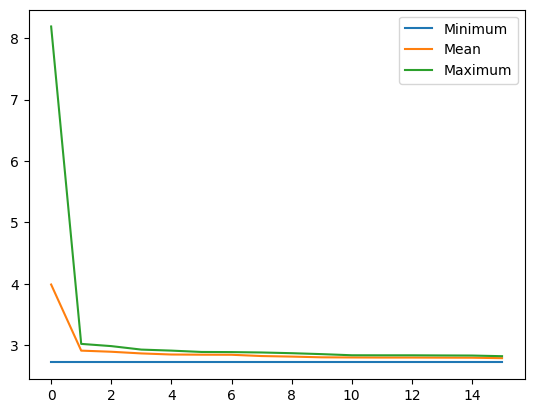




Best model: (score: 2.721290)
Learning rate: 0.1
Batch size: 32
Optimizer: <class 'keras.optimizers.optimizer_experimental.nadam.Nadam'>
L1: 6 selu
L2: 4 sigmoid
L3: 3 softplus




In [166]:
def anti_overfitting(chromosome):
    # Prevent overfitting by ensuring that models are a pyramid shape (i.e. the number of neurons in each layer decreases or atleast stays the same)
    chromosome[LAYERS_IDX] = sorted(chromosome[LAYERS_IDX], key=lambda x: x[HIDDEN_LAYER_SIZE_IDX], reverse=True)
    return chromosome

def init_population():
    # Create the initial population
    population = list()
    for _ in range(ELITISM):
        layers = list()
        lcount = random.choice(HIDDEN_LAYER_COUNTS)
        for i in range(MAX_LAYER_COUNT):
            if i < lcount:
                layers.append([
                    random.choice(HIDDEN_LAYER_SIZES),
                    random.choice(ACTIVATIONS)
                ])
            else:
                # Allow the model to have less layers than the maximum, it is not always beneficial to have more layers
                layers.append([0, "none"])

        chromosome = [
            random.choice(LEARNING_RATE),
            random.choice(BATCH_SIZES),
            random.choice(OPTIMIZERS),
            layers
        ]
        population.append(anti_overfitting(chromosome))
    return population

# Dictionary that allows the mutation of a parameter to be done a bit cleaner
MUTATIONS = {
    LEARNING_RATE_IDX: lambda: random.choice(LEARNING_RATE),
    BATCH_SIZE_IDX: lambda: random.choice(BATCH_SIZES),
    OPTIMIZER_IDX: lambda: random.choice(OPTIMIZERS),
    LAYERS_IDX: lambda: random.choice(HIDDEN_LAYER_COUNTS),
    LAYERS_IDX + 1 + HIDDEN_LAYER_SIZE_IDX: lambda: random.choice(HIDDEN_LAYER_SIZES),
    LAYERS_IDX + 1 + HIDDEN_LAYER_ACTIVATION_IDX: lambda: random.choice(ACTIVATIONS)
}

# The number of adjustable parameters in a chromosome
PARAM_COUNT = LAYERS_IDX + MAX_LAYER_COUNT * 2

def mutate(chromosome):
    # During a mutation, randomise half (randomly selected) of the parameters
    mutate_idxs = random.sample(range(PARAM_COUNT), int(PARAM_COUNT / 2))
    for idx in mutate_idxs:
        if idx < LAYERS_IDX:
            chromosome[idx] = MUTATIONS[idx]()
        else:
            layer_idx = (idx - LAYERS_IDX) // 2 # 0 - 2 hopefully (inclusive)
            target_idx = (idx - LAYERS_IDX) % 2 # 0 or 1
            chromosome[LAYERS_IDX][layer_idx][target_idx] = MUTATIONS[LAYERS_IDX + 1 + target_idx]()
            # non_target is the opposite of target_idx (0 or 1)
            non_target = int(not target_idx)
            if chromosome[LAYERS_IDX][layer_idx][non_target] in [0, "none"]:
                chromosome[LAYERS_IDX][layer_idx][non_target] = MUTATIONS[LAYERS_IDX + 1 + non_target]()
    return anti_overfitting(chromosome)    

def possible_mutation(chromosome):
    # Randomly decide whether to mutate a chromosome or not
    return mutate(chromosome) if random.random() < MUTATION_RATE else chromosome

def crossover_index(idx, p1, p2, c1, c2):
    # Crossover a single parameter (at index idx) from the parents to the children
    if idx < LAYERS_IDX:
        c1[idx] = p1[idx]
        c2[idx] = p2[idx]
        return c1, c2
    
    layer_idx = (idx - LAYERS_IDX) // 2 # 0 - 2
    target_idx = (idx - LAYERS_IDX) % 2 # 0 or 1

    c1[LAYERS_IDX][layer_idx][target_idx] = p1[LAYERS_IDX][layer_idx][target_idx]
    c2[LAYERS_IDX][layer_idx][target_idx] = p2[LAYERS_IDX][layer_idx][target_idx]
    non_target_idx = int(not target_idx)
    for c in [c1, c2]:
        if c[LAYERS_IDX][layer_idx][non_target_idx] in [0, "none"]:
            c[LAYERS_IDX][layer_idx][non_target_idx] = MUTATIONS[LAYERS_IDX + 1 + non_target_idx]()
    return anti_overfitting(c1), anti_overfitting(c2)

def crossover(chromosome1, chromosome2):
    # Crossover the parameters of two chromosomes to create two new children
    crossover_idx = random.sample(range(PARAM_COUNT), int(PARAM_COUNT/2))
    # Init children with empty values
    c1 = c2 = [None] * LAYERS_IDX + [[[0, "none"] for _ in range(MAX_LAYER_COUNT)]]
    for idx in range(PARAM_COUNT):
        if idx in crossover_idx:
            pa, pb = chromosome1, chromosome2
        else:
            pb, pa = chromosome1, chromosome2
        c1, c2 = crossover_index(idx, pa, pb, c1, c2)
    return possible_mutation(c1), possible_mutation(c2)

def get_model(chromosome, X_train, y_train):
    # Create a fresh model from the chromosome, if the there are multiple cycles this is important, else we will train the same model multiple times
    model = keras.Sequential()
    # ensure no non-empty layers without activation
    for layer in chromosome[LAYERS_IDX]:
        if layer[HIDDEN_LAYER_SIZE_IDX] > 0 and layer[HIDDEN_LAYER_ACTIVATION_IDX] == "none":
            layer[HIDDEN_LAYER_ACTIVATION_IDX] = MUTATIONS[LAYERS_IDX + 1 + HIDDEN_LAYER_ACTIVATION_IDX]()
    model.add(layers.Dense(chromosome[LAYERS_IDX][0][HIDDEN_LAYER_SIZE_IDX], activation=chromosome[LAYERS_IDX][0][HIDDEN_LAYER_ACTIVATION_IDX], input_shape=(X_train.shape[1],)))
    for i in range(1, MAX_LAYER_COUNT):
        if chromosome[LAYERS_IDX][i][HIDDEN_LAYER_SIZE_IDX] > 0:
            model.add(layers.Dense(chromosome[LAYERS_IDX][i][HIDDEN_LAYER_SIZE_IDX], activation=chromosome[LAYERS_IDX][i][HIDDEN_LAYER_ACTIVATION_IDX]))
    model.add(layers.Dense(1))
    model.compile(loss=LOSS, optimizer=chromosome[OPTIMIZER_IDX](chromosome[LEARNING_RATE_IDX]), metrics=["mae", "mse"])
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=chromosome[BATCH_SIZE_IDX], verbose=0, callbacks=CALLBACKS, validation_split=VALIDATION_SPLIT)
    return model

def unnormalise_y(y):
    min, max = normalisation_bounds[Y]
    return (y * (max - min) + min)

def pretty_print(chromosome):
    # Just print the chromosome in a readable format
    print(f"Learning rate: {chromosome[LEARNING_RATE_IDX]}")
    print(f"Batch size: {chromosome[BATCH_SIZE_IDX]}")
    print(f"Optimizer: {chromosome[OPTIMIZER_IDX]}")
    print(f"L1: {chromosome[LAYERS_IDX][0][HIDDEN_LAYER_SIZE_IDX]} {chromosome[LAYERS_IDX][0][HIDDEN_LAYER_ACTIVATION_IDX]}")
    print(f"L2: {chromosome[LAYERS_IDX][1][HIDDEN_LAYER_SIZE_IDX]} {chromosome[LAYERS_IDX][1][HIDDEN_LAYER_ACTIVATION_IDX]}")
    print(f"L3: {chromosome[LAYERS_IDX][2][HIDDEN_LAYER_SIZE_IDX]} {chromosome[LAYERS_IDX][2][HIDDEN_LAYER_ACTIVATION_IDX]}")
    print("\n")

unylabel = unnormalise_y(test_labels)

def evaluate_chromosome(chromosome):
    pretty_print(chromosome)
    scores = []
    for _c in range(CYCLES):
        model = get_model(chromosome, train_features, train_labels)
        epochs = len(model.history.history["loss"])
        yhat = model.predict(test_features).flatten()
        if np.isnan(yhat).any():
            print("NaN in prediction")
            mae = None
        else:
            unyhat = unnormalise_y(yhat)
            mae = mean_squared_error(unylabel, unyhat, squared=False) # Use RMSE to prefer models with lower error variance
        print(f"Cycle {_c} -> MAE: {mae} (epochs: {epochs})")
        scores.append(mae)
    score = np.mean(scores)
    print(f"Chromosome score: {score} | finshed @ {time.ctime()}")
    return score

"""
Evaluated chromosome structure:
[
    fitness,
    chromosome...
]
"""

def evaluate_population(population):
    # Evaluate the population, if the chromosome has already been evaluated, use the saved value
    evaluated_population = []
    for e_chromosome in population:
        score, chromosome = e_chromosome[0], e_chromosome[1]
        if score is None:
            score = evaluate_chromosome(chromosome)
        evaluated_population.append([score, chromosome])
    return evaluated_population

elite_generation = []

def crossover_elites(evaluated_population):
    # We take ELITISM number of chromosomes, sorting by fitness (10000 is for None values)
    elites = sorted(evaluated_population, key=lambda x: x[0] or 10000)[:ELITISM]
    minimum, maximum = elites[0][0], elites[-1][0]
    mean = np.mean([x[0] for x in elites])
    elite_generation.append([minimum, mean, maximum])
    print(f"Elites | Minimum: {minimum} < {mean} > Maximum: {maximum}")
    random.shuffle(elites)
    population = elites.copy() # We keep the elites in the population
    for i in range(0, ELITISM, 2):
        c1, c2 = crossover(elites[i][1], elites[i+1][1])
        population.append([None, c1])
        population.append([None, c2])
    return population

spike = [[0.01, 48, optimizers.Nadam, [[4, "exponential"], [3, "softplus"], [3, "softmax"]]]]


# When I first ran this, the "spike" list was empty, I have added it here so that  
#  you can run the algorithm for only a few generations and still get a good result.
inital_pop = spike + init_population()[len(spike):]

def get_best_chromosome(inital_pop):
    population = [[None, x] for x in inital_pop]
    current_generation = 0
    while current_generation <= GENERATION_COUNT:
        print(f"\nGeneration {current_generation} started @ {time.ctime()}\n")
        elites = evaluate_population(population)
        pickle.dump(elites, open(f"GA/Generation_{current_generation}-elites.pkl", "wb"))
        population = crossover_elites(elites)
        current_generation += 1
    # Plot the evolution of the best chromosome using elite_generation
    # Which is a list of [minimum, mean, maximum] for each generation
    plt.plot([x[0] for x in elite_generation], label="Minimum")
    plt.plot([x[1] for x in elite_generation], label="Mean")
    plt.plot([x[2] for x in elite_generation], label="Maximum")
    plt.legend()
    plt.show()

    return sorted(elites, key=lambda x: x[0] or 10000)[0]
        
fittest_model = [2, [0.01, 48, optimizers.Nadam, [[4, "exponential"], [3, "softplus"], [3, "softmax"]]]]
fittest_model = get_best_chromosome(inital_pop) # Takes ~ 1 hour
print(f"\n\n\nBest model: (score: {fittest_model[0]:2f})")
pretty_print(fittest_model[1])


In [ ]:
# Create a new model with the best chromosome
model = get_model(fittest_model[1], train_features, train_labels)

# Evaluate the model
predictions = model.predict(test_features).flatten()

mlp_predictions = denormalise_y(predictions, *normalisation_bounds[Y])

print(f"Mean absolute error: {mean_absolute_error(unnormalised_test_labels, mlp_predictions):0.2f} MPG")
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(unnormalised_test_labels, mlp_predictions):0.3f}%")
print(f"Root mean squared error: {mean_squared_error(unnormalised_test_labels, mlp_predictions, squared=False):0.2f} MPG")


3/3 [==============================] - 0s 1ms/step
Mean absolute error: 2.28 MPG
Mean absolute percentage error: 0.100%
Root mean squared error: 2.96 MPG


## Results analysis

Plotting the results of the models, and the residuals of both models:


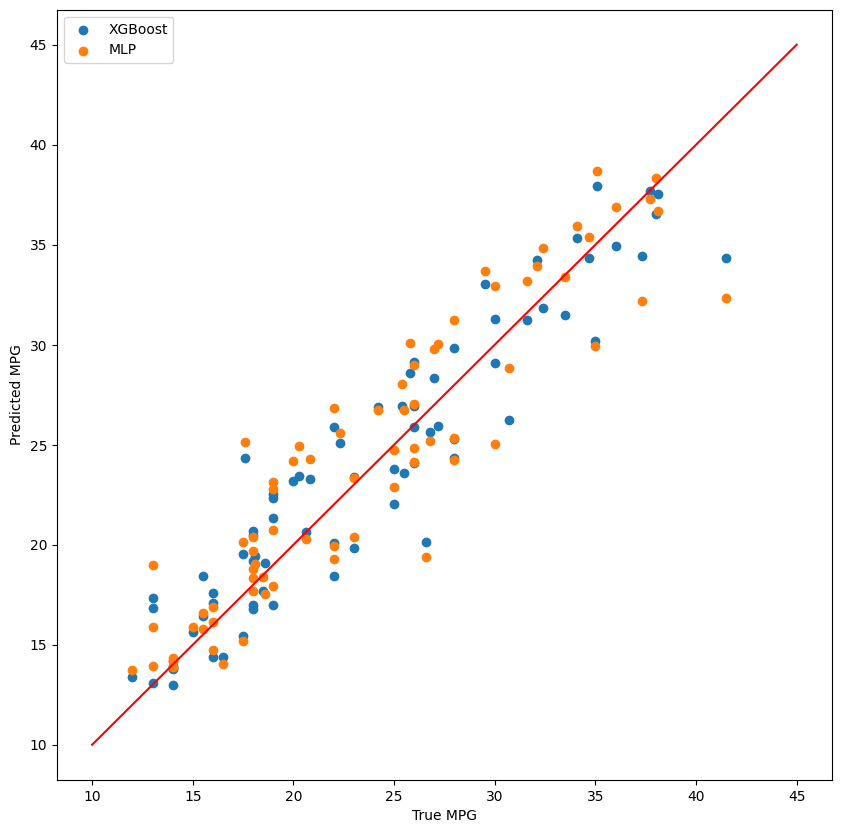

In [ ]:
# Plot both xgb_predictions and mlp_predictions on the same graph
# With a red line for the perfect prediction

plt.figure(figsize=(10, 10))
plt.scatter(unnormalised_test_labels, xgb_predictions, label="XGBoost")
plt.scatter(unnormalised_test_labels, mlp_predictions, label="MLP")
plt.plot([10, 45], [10, 45], color="red")
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.legend()
plt.show()


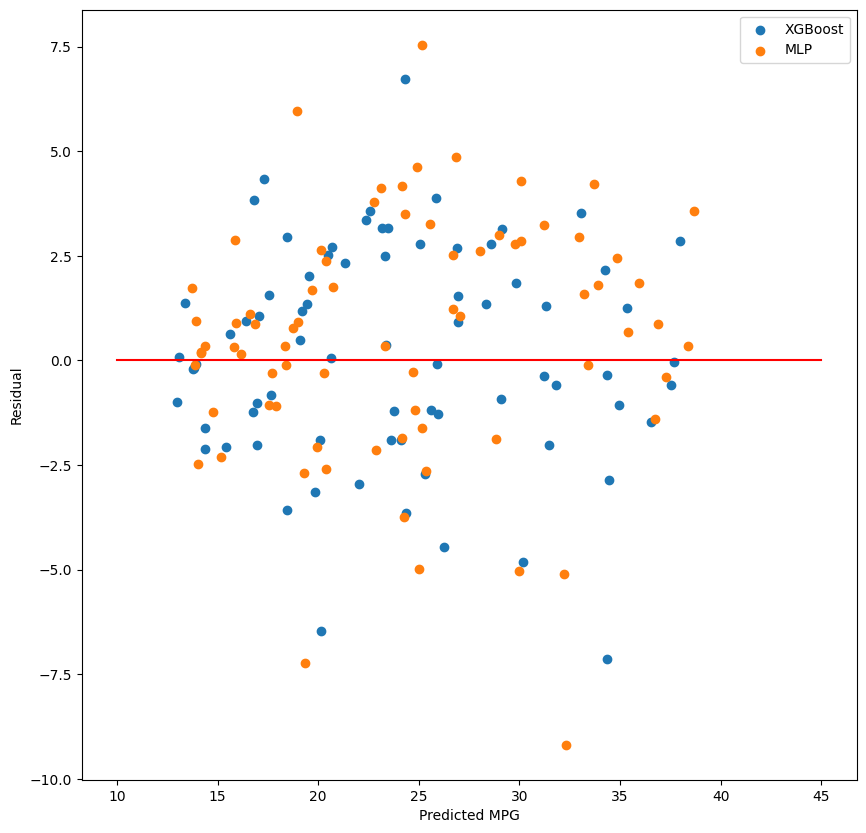

In [ ]:
# Plot the both of the residuals on the same graph

plt.figure(figsize=(10, 10))
plt.scatter(xgb_predictions, xgb_predictions - unnormalised_test_labels, label="XGBoost")
plt.scatter(mlp_predictions, mlp_predictions - unnormalised_test_labels, label="MLP")
plt.plot([10, 45], [0, 0], color="red")
plt.xlabel("Predicted MPG")
plt.ylabel("Residual")
plt.legend()
plt.show()

Both models have a similar MAE, however the XGBoost has a lower RMSE, this indicates that the XGBoost is has a smaller variance in errors (Wesner, 2016), and is more likely to generalise well to new data, the MLP on the other hand is more likely to be overfitted to the data, it also has a few large errors, which is not ideal. In addition to this the XGBoost is much easier to explain to others, as it is a tree-based model, and the decision trees can be visualised which is not possible with the MLP.

## Conclusion

Both models have an error of ~2 MPG which is not perfect, however the variance in MPG of a car can be affected by many factors that aren't included in this dataset, such as the driver, the road conditions, and the weather. If more data was available then the MLP could be a better model, however with the relatively small dataset of ~400 instances, the underlying patterns in the data are likely to be simple, or not adequately captured. However on this particular dataset I'd recommend the XGBoost model, as it has a lower variance in errors, and thus is more reliable.

# References

Chen, T. and Guestrin, C. (2016) “XGBoost,” Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining [Preprint]. Available at: https://doi.org/10.1145/2939672.2939785. 

Raji, I.D. et al. (2022) “Simple deterministic selection-based genetic algorithm for hyperparameter tuning of Machine Learning Models,” Applied Sciences, 12(3), p. 1186. Available at: https://doi.org/10.3390/app12031186. 

Wesner, J. (2016) Mae and RMSE - which metric is better?, Medium. Human in a Machine World. Available at: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d (Accessed: February 2, 2023). 
